In [1]:
# import necessary libraries

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import scipy.stats

In [2]:
def minimal_ESN(data, n_units = 1000, leak_rate = 0.3, train = 0.6, test = 0.4, init = 100, reg = 1e-8):
    
    # data - T x D numpy array of the input time series
    # n_neurons - number of units in the resevoir, by default 1000 units
    # leak_rate - leaking rate of the resevoir units, by default 0.3
    # train - proportion of data to be used for training
    # test - proportion of data to be used for testing
    # init - amount of data points to be used for initialisation
    # reg - regularization parameter for ridge regression of output weights, by default 1e-8
    
    D, T = data.shape
    
    # standardize data
    #scaler = StandardScaler()
    #scaler.fit(data)
    #data = scaler.transform(data)
    
    # split up data into train and test sets
    train_len = 2000 #int(np.floor(train * T))
    test_len = 2000 #int(np.floor((T - train_len) * 0.5))
    
    #train_data = data[:train_len,:]
    #test_data = data[train_len:,:]
    
    
    # initialise size ESN resevoir
    inSize = D
    outSize = D
    a = leak_rate
    
    np.random.seed(42)
    
    # initialise the input matrix weights
    W_in = (np.random.rand(n_units,1 + inSize) - 0.5) * 1
    # initialise resevoir matrix
    W = np.random.rand(n_units, n_units) - 0.5
    
    # normalise and set the spectral radius
    print('Computing spectral radius...')
    rhoW = np.max(np.abs(np.linalg.eig(W)[0]))
    print('done.')
    W *= 1.25 / rhoW
    
    # allocate memory for design matrix
    X = np.zeros((1 + inSize + n_units, train_len - init))
    # set corresponing target matrix
    Yt = data[:, init + 1 : train_len + 1]
    
    # run resevoir with data and get x
    x = np.zeros((n_units,1))
    
    for t in range(train_len):
        
        u = np.reshape(data[:,t],(D,1))
        u = np.vstack((1,u))
        x = (1-a)*x + a*np.tanh((W_in @ u) + (W @ x))
        
        
        if t >= init:
            #print(x.shape)
            #print(u.shape)
            #print(X[:,t-init].shape)
            #print(np.vstack((u,x))[:,0].shape)
            X[:,t-init] = np.vstack((u,x))[:,0]
            
    
    # train output weights using ridge regression
    W_out = np.linalg.solve(X @ X.T + reg*np.eye(1 + inSize + n_units), X @ Yt.T).T
    
    # run trained ESN in generative mode
    Y = np.zeros((outSize, test_len))
    u = data[:, train_len]
    
    for t in range(test_len):
        u = np.reshape(u,(D,1))
        u = np.vstack((1,u))
        x = (1-a)*x + a*np.tanh((W_in @ u) + (W @ x))
        y = W_out @ np.vstack((u, x))
        Y[:,t] = y[:,0]
        #u = y
        u = data[:, train_len+t+1] 
    

    errorLen = 500
    mse = np.mean((data[:,train_len+1:train_len+errorLen+1] - Y[:, 0:errorLen])**2, axis = 1)
    print('MSE = ' + str( mse ))
    
    # plot some signals
    plt.figure(1).clear()
    plt.plot(data[:,train_len+1:train_len+test_len+1].T, 'g' )
    plt.plot( Y.T, 'b' )
    plt.title('Target and generated signals $y(n)$ starting at $n=0$')
    plt.legend(['Target signal', 'Free-running predicted signal'])

    plt.figure(2).clear()
    plt.plot( X[0:20,0:200].T )
    plt.title(r'Some reservoir activations $\mathbf{x}(n)$')

    plt.figure(3).clear()
    plt.bar( np.arange(1+inSize+n_units), W_out[0].T )
    plt.title(r'Output weights $\mathbf{W}^{out}$')

    plt.show()

Computing spectral radius...
done.
MSE = [1.76880342e-08]


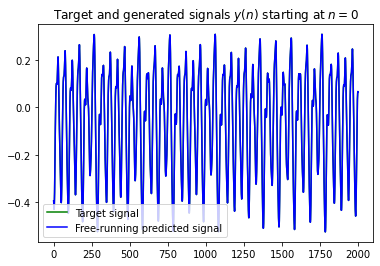

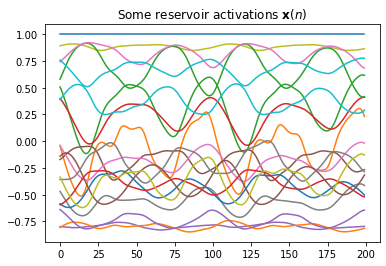

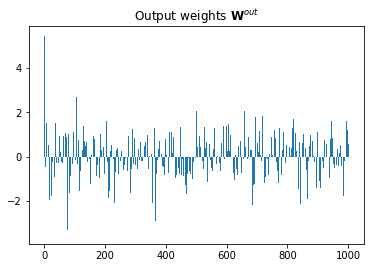

In [3]:
MackeyGlass = np.loadtxt('MackeyGlass_t17.txt')

MackeyGlass = np.reshape(MackeyGlass, (1, len(MackeyGlass)))

minimal_ESN(MackeyGlass)

In [225]:
# define function to generate samples from the above described coupled logistic map

def coupled_logistic(x0, y0, rx, ry, b_xy, b_yx, a_x = 0.0, a_y = 0.0, obs_per_year=24, years=400, seasonal = False):
    
    """
    Creates coupled logistic map of the form

    $X(t+1) = X(t)(rx - rx*X(t) - b_yx*Y(t)) + a_x$

    $Y(t+1) = Y(t)(ry - ry*Y(t) - b_xy*X(t)) + a_y$

    :param x0: initial value for X
    :param y0: initial value for Y
    :param rx: coefficient for x expression
    :param ry: coefficient for y expression
    :param b_xy: interspecific interaction of y on x
    :param b_yx: interspecific interaction of x on y
    :param a_x: strength of x seasonality
    :param a_y: strength of y seasonality
    :param seasonal: controls whether seasonality is added. Default is no seasonality
    :return: (logistic map of x, logistic map of y)
    """
    
    # initialise seasonality 
    if seasonal:
        # generate sinusodial seasonal component
        s = np.sin(np.linspace(0, 2 * np.pi, obs_per_year + 1)) # why 24 + 1
        seasonality = np.tile(s[:-1], years) # and why then exclude the last element
    else:
        seasonality = 0
    
    # initialise x_t and y_t
    x_t = np.zeros(int(obs_per_year * years))
    y_t = np.zeros(int(obs_per_year * years))
    x_t[0] = x0
    y_t[0] = y0
    
    for i in range(obs_per_year * years - 1):
        x_t[i + 1] = x_t[i] * (rx - rx * x_t[i] - b_yx * y_t[i-1]) #+ np.random.normal(0,0.05,1)
        y_t[i + 1] = y_t[i] * (ry - ry * y_t[i] - b_xy * x_t[i-1]) #+ np.random.normal(0,0.05,1)
    
    # add seasonality if there is any
    x_t += a_x * seasonality
    y_t += a_y * seasonality
    
    return x_t, y_t

In [232]:
x_t , y_t = coupled_logistic(0.9, 0.9, 3.72, 3.72, 0.1, 0.1, 0.3, 0.3, seasonal = False)
i = 0
x_t = np.reshape(x_t[i:], (len(x_t)-i,1))
y_t = np.reshape(y_t[:9600-i], (len(y_t)-i,1))
print(x_t.shape)
print(y_t.shape)
data_log = np.concatenate((x_t, y_t), axis = 1)

(9600, 1)
(9600, 1)


In [233]:
# standardize data
scaler = StandardScaler()
scaler.fit(data_log)
data_log = scaler.transform(data_log)
data_log = data_log.T
print(data_log.shape)
print(np.var(data_log, axis = 1))

(2, 9600)
[1. 1.]


Computing spectral radius...
done.
MSE = [1.24654834e-10 1.24654834e-10]


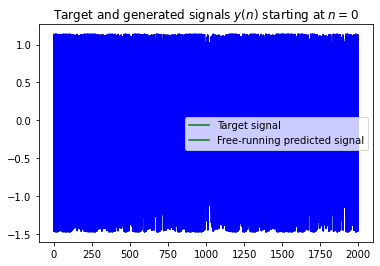

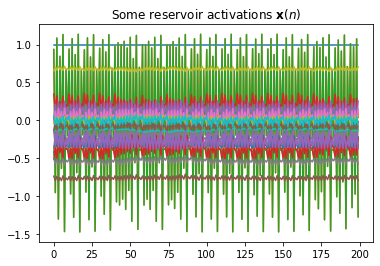

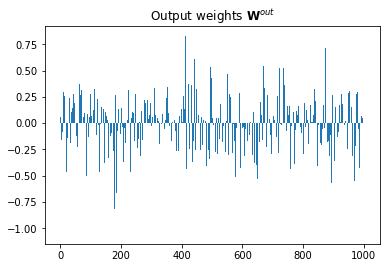

In [234]:
minimal_ESN(data_log, leak_rate = 0.3, reg = 1e-8)

In [9]:
minimal_ESN(data_log)

Computing spectral radius...
done.
MSE = [0.91063766 0.91063766]


In [30]:
def data_matlabcode():
    
    x = np.zeros(6000)
    y = np.zeros(6000)
    
    x = np.reshape(x, (1,6000))
    y = np.reshape(y, (1,6000))
    
    x[0] = 0.1
    y[0] = 0.2
    
    for i in range(1,13):
        x[:,i] = x[:,i-1] * (3.78 - 3.78*x[:,i-1])
        y[:,i] = y[:,i-1] * (3.77 - 3.77*y[:,i-1])
        
    for i in range(13, 6000):
        x[:,i] = x[:,i-1] * (3.78 - 3.78*x[:,i-1] - 0.01*y[:,i-1])
        y[:,i] = y[:,i-1] * (3.77 - 3.77*y[:,i-1] - 0.01*x[:,i-1])
        
    # generate sinusodial seasonal component
    s = np.sin(np.linspace(0, 2 * np.pi, 24 + 1)) # why 24 + 1
    seasonality = np.tile(s[:-1], 250) # and why then exclude the last element
    #print(len(seasonality))
    
    x += 0.1 * seasonality
    y += 0.1 * seasonality
    
    return x, y, np.concatenate((x,y), axis = 0)

(1, 6000)
(1, 6000)
(2, 6000)


<function matplotlib.pyplot.show(close=None, block=None)>

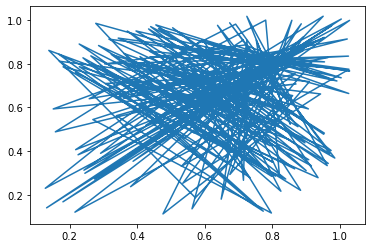

In [31]:
x1, y1 , xy1 = data_matlabcode()

print(x1.shape)
print(y1.shape)
print(xy1.shape)

plt.plot(x1[0,5800:], y1[0,5800:])
plt.show

In [32]:
minimal_ESN(x1, n_units = 1000, leak_rate = 0.3, train = 0.6, test = 0.4, init = 100, reg = 1e-5)
minimal_ESN(y1, n_units = 1000, leak_rate = 0.3, train = 0.6, test = 0.4, init = 100, reg = 1e-5)
minimal_ESN(xy1, n_units = 1000, leak_rate = 0.3, train = 0.6, test = 0.4, init = 100, reg = 1e-5)

Computing spectral radius...
done.
MSE = [594.03355545]
Computing spectral radius...
done.
MSE = [929.78513257]
Computing spectral radius...
done.
MSE = [238.93656958 193.99294086]


In [12]:
def causal_ESN(X_data, Y_data, n_units = 1000, leak_rate = 1, train = 0.5, test = 0.5, init = 50, reg = 0):
    
    # data - T x D numpy array of the input time series
    # i - what lag to test
    # n_neurons - number of units in the resevoir, by default 1000 units
    # leak_rate - leaking rate of the resevoir units, by default 0.3
    # train - proportion of data to be used for training
    # test - proportion of data to be used for testing
    # init - amount of data points to be used for initialisation
    # reg - regularization parameter for ridge regression of output weights, by default 1e-8
    
    D1, T1 = X_data.shape
    D2, T2 = Y_data.shape
    
    #print(X_data.shape)
    
    # standardize data
    #scaler = StandardScaler()
    #scaler.fit(data)
    #data = scaler.transform(data)
    
    # split up data into train and test sets
    train_len = int(np.floor(train * T1))
    test_len = int(np.floor(T1 - train_len))
    
    #print(train_len)
    #print(test_len)
    #print(train_len + test_len)
    
    train_x = 1.0 * X_data[:train_len,:]
    test_x = 1.0 * X_data[train_len:,:]
    
    train_y = 1.0 * Y_data[:train_len,:]
    test_y = 1.0 * Y_data[train_len:,:]
    
    
    # initialise size ESN resevoir
    inSize = D1
    outSize = D1
    a = leak_rate
    
    np.random.seed(42)
    
    # initialise the input matrix weights
    W_in = (np.random.rand(n_units,1 + inSize) - 0.5) * 1
    # initialise resevoir matrix
    W = np.random.rand(n_units, n_units) - 0.5
    
    # normalise and set the spectral radius
    print('Computing spectral radius...')
    rhoW = np.max(np.abs(np.linalg.eig(W)[0]))
    print('done.')
    W *= 10.5 / rhoW
    
    # allocate memory for design matrix
    X = np.zeros((1 + inSize + n_units, train_len - init))
    # set corresponing target matrix
    Yt = Y_data[:, init + 1 : train_len + 1]
    
    # run resevoir with data and get x
    x = np.zeros((n_units,1))
    
    for t in range(train_len):
        
        u = np.reshape(X_data[:,t],(D1,1))
        u = np.vstack((1,u))
        x = (1-a)*x + a*np.tanh((W_in @ u) + (W @ x))
        
        
        if t >= init:
            X[:,t-init] = np.vstack((u,x))[:,0]
            
    
    # train output weights using ridge regression
    W_out = np.linalg.solve(X @ X.T + reg*np.eye(1 + inSize + n_units), X @ Yt.T).T
    
    # run trained ESN in generative mode
    Y_train = np.zeros((outSize, train_len - init))
    Y_test = np.zeros((outSize, test_len - init))
    u = X_data[:,0]
    
    for t in range(train_len):
        u = np.reshape(u,(D1,1))
        u = np.vstack((1,u))
        x = (1-a)*x + a*np.tanh((W_in @ u) + (W @ x))
        y = W_out @ np.vstack((u, x))
        #u = y
        u = X_data[:,t+1]
        if t >= init:
            Y_train[:,t - init] = y[:,0]
        
    u = X_data[:,train_len + 1]
        
    for t in range(test_len-1):
        u = np.reshape(u,(D1,1))
        u = np.vstack((1,u))
        x = (1-a)*x + a*np.tanh((W_in @ u) + (W @ x))
        y = W_out @ np.vstack((u, x))
        #u = y
        u = X_data[:, train_len+t+1]
        if t >= init:
            Y_test[:,t - init] = y[:,0]
    
    
    X1 = X_data[:,init:train_len+1]
    X2 = X_data[:,train_len + init + 1:]
    errorLen = 500
    #print(Y_data[:,train_len+1:train_len+errorLen+1].shape)
    #print(Y[:, 0:errorLen].shape)
    #mse = np.mean((Y_data[:,train_len+1:train_len+errorLen+1] - Y[:, 0:errorLen])**2, axis = 1)
    corr = scipy.stats.kendalltau(np.concatenate((X1, X2), axis = 1), np.concatenate((Y_train, Y_test), axis = 1))[0]
    #print('Corr = ' + str( corr ))
    #print('MSE = ' + str( mse ))
    
    return corr

In [13]:
causal_ESN(x1[:,15000:], y1[:,15000:], n_units = 400, leak_rate = 1, train = 0.5, test = 0.5, init = 100, reg = 0)

Computing spectral radius...
done.


-0.11316697923178441

Computing spectral radius...
done.
Computing spectral radius...
done.
Computing spectral radius...
done.
Computing spectral radius...
done.
Computing spectral radius...
done.
Computing spectral radius...
done.
Computing spectral radius...
done.
Computing spectral radius...
done.
Computing spectral radius...
done.
Computing spectral radius...
done.
Computing spectral radius...
done.
Computing spectral radius...
done.
Computing spectral radius...
done.
Computing spectral radius...
done.
Computing spectral radius...
done.
Computing spectral radius...
done.
Computing spectral radius...
done.
Computing spectral radius...
done.
Computing spectral radius...
done.
Computing spectral radius...
done.
Computing spectral radius...
done.
Computing spectral radius...
done.
Computing spectral radius...
done.
Computing spectral radius...
done.
Computing spectral radius...
done.
Computing spectral radius...
done.
Computing spectral radius...
done.
Computing spectral radius...
done.
Computing spectral r

<function matplotlib.pyplot.show(close=None, block=None)>

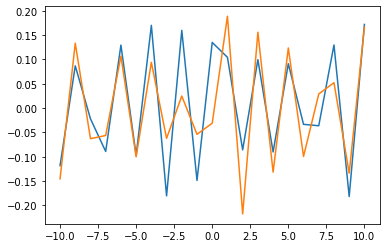

In [15]:
corrs = np.zeros((2, 21))

x1 = x1[:,15000:]
y1 = y1[:,15000:]

for i in range(-10,11):
    
    x1_data = x1[:, 10 - i: 5000 - 10 - i]
    y1_data = y1[:, 10: 5000 - 10]
    
    corrs[0, i] = causal_ESN(x1_data, y1_data, n_units = 400, leak_rate = 1, train = 0.5, test = 0.5, init = 100, reg = 0)
    
    x2_data = x1[:, 10: 5000 - 10]
    y2_data = y1[:, 10 - i: 5000 - 10 - i]
    
    corrs[1, i] = causal_ESN(y2_data, x2_data, n_units = 400, leak_rate = 1, train = 0.5, test = 0.5, init = 100, reg = 0)
    
plt.plot(range(-10,11), corrs[0,:])
plt.plot(range(-10,11), corrs[1,:])

plt.show
    